# Sensitivity Analysis of the HYMOD Model

This tutorial has been developed to showcase some of the sensitivity analysis and uncertainty quantification concepts and tools that have been explained in the white paper. The tutorial includes the following sections:

[1- Introduction to a simple hydrologic model (HYMOD)](#hymod) <br>
[2- An overview of sensitivity analysis using SALib](#sensitivity)  <br>
[3- Calculation of sensitivity analysis metrics](sa_metrics)  <br>
[4- Time-varying sensitivity analysis](#TVSA)  <br>
[5- Regional sensitivity analysis](#RSA)  <br>
[6- Generalized Likelihood Uncertainty Estimation (GLUE)](#GLUE)  <br>
[7- Pre-Calibration](#precalibration) <br>

<b> It is important to note that, </b> although in this tutorial we focus on HYMOD, which is a hydrologic model, it can also be thought of as an example of models that abstract complex non-linear systems. Therefore, many of the contents and methods that we use in the tutorial can be used for numerical models that simulate other complex non-linear systems.

<a id='hymod'></a> 
# 1- HYMOD 

HYMOD is a simple hydrologic model (rainfall-runoff model) that simulates key hydrologic fluxes such as infiltration, streamflow and evapotranspiration. The model has been originally developed and used for river flow forecasting, however, in the last two decades the model has been widely used to explore different sensitivity analysis (e.g., [Herman et al, 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20124)), uncertainty quantification (e.g.,  [Smith et al, 2008](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006WR005205)), and optimization (e.g., [Ye et al, 2014](https://www.sciencedirect.com/science/article/pii/S0022169414006362?casa_token=IRqE19Hkfa8AAAAA:_fXOqfwpzxMpchvu8_0njCe0Ok9H29Gyw2F46l9PzG9UVODDTUg6wIOSiyp6uybGevNVnZ7N)) concepts.

There are two main assumptions in the model: <br>
1- rainfall is generated through infiltration excess overland flow. <br>
2- runoff generation can be formulated by the probability-distributed principle (Moore, 1985). Therefore the cumulative rate storage capacity <i>(F(C))</i> can be calculated using the following relationship:

$$F(C) = 1 - (1 - \frac{C}{C_{MAX}})^{B_{exp}}$$

where **C** is the water storage capacity; **$C_{MAX}$** is the parameters describing basin maximum water storage capacity (mm); and **$B_{exp}$** is the parameters describing the degree of spatial variability within the basin between.


The portion of precipitation that exceeds the water storage capacity is treated as runoff. The evapotranspiration is equal to potential evapotranspiration (PET) if enough water is available. Otherwise, it equals the available water storage.

Then based on a parameter *(Alpha)*, the runoff is divided into quick flow and slow flow, which are routed through three identical quick flow tanks (Q1, Q2, Q3) and a parallel slow flow tank, respectively.

The flow rates in the routing system are described by the resident time in the quick tanks Kq (day) and the slow tank Ks (day), respectively.


![alt text](../Schematic-representation-of-the-HYMOD-conceptual-watershed-model.png "Title")

Vrugt et al,(2008)

# First we need to import Python libraries that we need in this tutorial 

import pandas as pd
from Hymod_functions import hymod_main
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
import math


### 1-1 Model Parameters
**$C_{MAX}$**: parameters describing basin maximum water storage capacity (mm)

**$B_{exp}$**:      parameters describing the degree of spatial variability within the basin between 0 and Huz

**Alp**:    Fraction of runoff contributing to quick flow 

**Kq**:     Quick flow residence time of linear infinite reservoir (the Kq values of all three linear reservoirs are the same)

**Ks**:      Slow flow residence time of linear infinite reservoir



### 1-2 Input data

The HYMOD model only requires precipitation and potential evapotranspiration as inputs. The Leaf River example that we use here is also a widely used test case of HYMOD. The dataset also includes observed runoff that we later use to evaluate the performace of each sensitvity analysis sample set. 

We can use the following to read the input file:

In [1]:
# First we need to import necessary libraries 
import pandas as pd
import os
os.chdir('../')
from Hymod_functions import hymod_main
from matplotlib import pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
#from SALib.test_functions import Ishigami
import numpy as np
import seaborn as sns
from sklearn import metrics
import sklearn

In [10]:
# Here we load the HYMOD input file
leaf_data = pd.read_csv('LeafCatch.csv', sep=',')

# Extract the first eleven years of data
leaf_data = leaf_data.iloc[0:4015]
# There are only three columns in the file including precipitation, potential evapotranspiration and  streamflow 

In [11]:
leaf_data

,Precip,Pot_ET,Strmflw
0,0.00,4.60,0.29
1,0.00,4.31,0.24
2,0.00,4.33,0.21
3,0.00,4.78,0.19
4,0.00,2.91,0.18
...,...,...,...
4010,0.00,4.85,0.14
4011,0.03,3.59,0.14
4012,3.05,1.52,0.14
4013,0.76,2.37,0.14


### 1-3 Baseline Model Simulation

We can start our sensitivity analysis experiment with running HYMOD using its default parameters.


In [12]:
# We can use the following input parameters to generate a baseline simulated streamflow
Nq = 3  
Kq = 0.5   
Ks =  0.001 
Alp = 0.5  
Huz = 100  
B = 1.0    

# Note that the number of years is 11 years. One year of model warm-up and ten years of actual simulation
Model = hymod_main.main(Nq, Kq, Ks, Alp, Huz, B, 'LeafCatch.csv', ndays=4015)

### 1-4 Model Outputs

Model outputs include actual evapotranspiration, quick and fast streamflow, and combined runoff. In this tutorial we focus on the total daily runoff. We can use the following script to plot simulated streamflow against observed streamflow.

### Variables

**PP**:    Precipitation

**ET**:    Evapotranspiration

**OV**:    Runoff

**Qq**:    Quick Flow

**Qs**:    Slow Flow

**QQ**:    Streamflow (Quick Flow + Slow Flow)

**XHuz** and **XCuz**: Current moisture state of soil moisture accounting component (as depth XH or volume XC)

Text(0.5, 1.0, 'Observed vs. Simulated Streamflow')

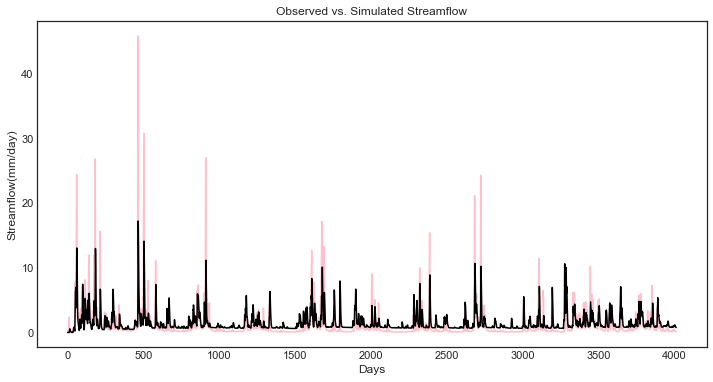

In [13]:
# Observed vs simulated streamflow

plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(range(0, len(leaf_data['Strmflw'])), leaf_data['Strmflw'], color= 'pink')
ax.plot(range(0, len(leaf_data['Strmflw'])), Model['Q'], color='black')

ax.set_ylabel('Streamflow(mm/day)')
ax.set_xlabel('Days')
plt.title('Observed vs. Simulated Streamflow')


<a id='sensitivity'></a> 
# 2- Sensitivity Analysis

Here we use the SALib Python library to explore how different HYMOD input parameters affect model streamflow simulations. For this exercise, we only use Sobol variance-based method. The following commands can be used to import SALib

In [14]:
# Import SALib modules that we need
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.analyze import delta

### 2-1 Sensitivity Analysis Input Samples
To conduct sensitivity analysis, we need to first define the ranges of all parameters, and after that, we use Sobol low discrepancy sequence to generate sample datasets. The following can be used to generate samples:

In [15]:
# Define the model inputs and their ranges
problem_hymod = {
    'num_vars': 5,
    'names': ['Kq', 'Ks', 'Alp', 'Huz', 'B'],
    'bounds': [#[1, 8],    # Nq
               [0.1, 1],  # Kq
               [0, 0.1],  # Ks
               [0, 1],    # Alp
               [0, 500],  # Huz
               [0, 2]]  # B             
}

# Generate samples
# keep in mind that, here I am spliting the range of each parameter into 100 pieces. 
# However This is an arbitrary number. 
param_values_hymod = saltelli.sample(problem_hymod, 300)

### 2-2 Model simulations for sensitivity analysis
Now we need to run the model for each of the sample sets. The following can be used to first create an empty data frame for all model outputs. Afterward, I run the model for each sample set and save the results in the data frame.

In [15]:
# Create a data frame to store model ouputs
# This data frame includes the warm-up period which is one year
Q_df_bw=pd.DataFrame.from_dict(Model["Q"])

#------------------------------------------------------------------------------
#    Model Simulation
#------------------------------------------------------------------------------  

for i_ps in range(0, len(param_values_hymod)):
    # Run model for each sensitivity analysis parameter sets
    Model_output = hymod_main.main(Nq, param_values_hymod[i_ps,0], param_values_hymod[i_ps,1], param_values_hymod[i_ps,2], 
                                   param_values_hymod[i_ps,3], param_values_hymod[i_ps,4], 'LeafCatch.csv', ndays=4015)
    
    # Save the simulated total flow discharge
    Q_df_bw["Q"+str(i_ps)]=pd.DataFrame.from_dict(Model_output["Q"])



KeyboardInterrupt: 

In [ ]:
# You can use the following to save your HYMOD simulations
Q_df_bw.to_csv("C:/Users/keyva/OneDrive/Documents/Cornell/project/IM3/Models/hymod/Hymod-SA-UC/output_flow_300.csv")

In [16]:
# Read previously saved HYMOD outputs
Q_df_bw=pd.read_csv("C:/Users/keyva/OneDrive/Documents/Cornell/project/IM3/Models/hymod/Hymod-SA-UC/output_flow_300.csv")

#### Model Warm-up
A hydrological model such as HYMOD usually includes ordinary differential equations that are sensitive to their initial condition. They also have components in their underlying formulation that have long memory meaning that past time steps can affect their current simulations. For example, Soil moisture or groundwater can hold water for a long time therefore they are often considered to have a long memory. They can affect the partitioning of water to runoff and infiltration, while also controlling the generation of base flow. Therefore, it is important to have a reasonable initial value for them. To achieve that hydrologists usually extend their simulation period and after the simulations, they remove that extended time period that has unreasonable groundwater or surface water values. This is called model-up and the time period is called the warm-up time period.

Here we extended our simulation for one year (from 10 years to 11 years) and we removed the first year of simulation, therefore our warm-up period is one year.

In [17]:
# Here we exclude the first year of simulation from our dataset
Q_df=Q_df_bw.iloc[365:4015,1:]
Q_df=Q_df.reset_index(drop=True)

leaf_data=leaf_data.iloc[365:4015,:].reset_index(drop=True)

### 2-3 Visual inspection of the model outputs

Here we create a graph that shows HYMOD streamflow outputs under different sample sets, and compare them with the observed streamflow.

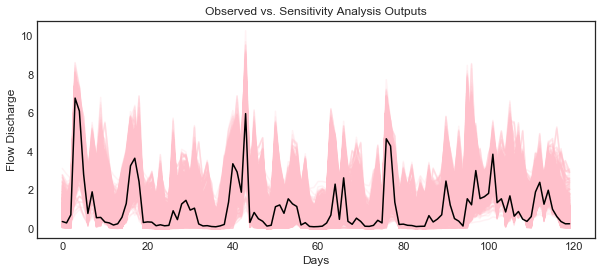

In [18]:
#------ Mean monthly indices 

# Here we add date columns to our simulated data frame
date_ts=pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year']=date_ts.year
Q_df['month']=date_ts.month
Q_df['day']=date_ts.day

# Aggregate the simulated observed streamflow to monthly
m_Q_df=Q_df.groupby(['year', 'month'])
agg_m_Q_df=m_Q_df.aggregate(np.mean)

# Here we add date columns to observed dataset 
# We assume that the dataset starts from 1/1/2000
date_ts=pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year']=date_ts.year
leaf_data['month']=date_ts.month
leaf_data['day']=date_ts.day

# Aggregate the daily observed streamflow to monthly
m_leaf_data=leaf_data.groupby(['year', 'month'])
agg_m_leaf_data=m_leaf_data.aggregate(np.mean)


fig_2, ax_fig_2=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(agg_m_Q_df)), agg_m_Q_df.iloc[:,2],  color="pink", alpha=0.2)
ax_fig_2.set_xlabel('Days')
ax_fig_2.set_ylabel('Flow Discharge')
#ax_fig_2.set_facecolor('white')

# This for loop prints all simulated streamflow cases under different sample sets 
for i_ps in range(0, len(param_values_hymod)):
    plt.plot(range(0, len(agg_m_Q_df)), agg_m_Q_df.iloc[:,i_ps],  color="pink", alpha=0.2)

plt.plot(range(0, len(agg_m_Q_df)), agg_m_leaf_data.iloc[0:len(agg_m_Q_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs')

plt.show()

<a id='sa_metrics'></a> 
# 3- Calculation of Sensitivity Analysis indices

There are different options to calculate sensitivity indices. For example, one can aggregate the outputs and calculate the indices. The following first aggregate model streamflow outputs and calculates the sensitivity indices.

### 3-1 Aggregated sensitivity analysis indices

This is the simplest way of calculating sensitivity analysis metrics, however, averaging all model response can lead to loss of information that we further explore in the following sections.

In [19]:
#------ Overall aggregated indices
    
Y=Q_df.iloc[:,1:Q_df.iloc[:,1:(Q_df.shape[1]-3)].shape[1]].mean().to_numpy()
# Perform analysis
#Si = sobol.analyze(problem_hymod, Y, print_to_console=False)
Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)

Parameter delta delta_conf S1 S1_conf
Kq 0.047767 0.008929 0.001976 0.005132
Ks 0.039572 0.009496 0.008824 0.006933
Alp 0.044352 0.008471 0.005607 0.006601
Huz 0.321240 0.014959 0.662446 0.025211
B 0.287992 0.015265 0.298623 0.028958


In [20]:
print('First order indices = ', Si['S1'])
#print('Total order indices = ', Si['ST'])
#print('Total interactions for each parameter = ', Si['ST']-Si['S1'])

First order indices =  [0.00197591 0.008824   0.00560709 0.66244596 0.29862314]


In [21]:
Si['S1'].sum()

0.9774761153780536

### 3-2 How do different performance metrics affect the results of our sensnitivity analysis?


Streamflow has many different properties. In this section, we discuss how the selection of metrics can lead to fundamentally different sensitivity analysis results. For example, one can only focus on aggregated streamflow metrics such as mean (what has been presented so far), or only on extreme events such as drought or floods.

Here we compare three different metrics:
1- Mean error (ME) 2- Root Mean Square Error (RMSE) 3- Log-Root Mean Square Error (Log(RMSE))

Each of these metrics focuses on a specific attribute of streamflow. For example, RMSE highlights the impacts of extreme flood events, while LOG(RMSE) focuses on model performance during low-flow events.

In [185]:
# Create an empty data frame to save different metrics

df_metrics_SA=pd.DataFrame(np.zeros((len(param_values_hymod),3)), columns=['ME', 'RMSE','LOG[RMSE]']) 

me=Q_df.iloc[:,0:len(param_values_hymod)].apply(lambda x: (x-leaf_data.loc[:,"Strmflw"]), axis=0)
mse=Q_df.iloc[:,0:len(param_values_hymod)].apply(lambda x: sklearn.metrics.mean_squared_error(x, leaf_data.loc[:,"Strmflw"]), axis=0 )
rmse = mse**(1/2)


df_metrics_SA.loc[:,'ME']=me.mean().values
df_metrics_SA.loc[:,'RMSE']=rmse.values
df_metrics_SA.loc[:,'LOG[RMSE]']=np.log10(rmse.values)

In [172]:
# Performance analysis
SA_df_4=pd.DataFrame(np.zeros((3,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
SA_df_4T=pd.DataFrame(np.zeros((3,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

for i_ps in range(0, 3):
    Y=df_metrics_SA.iloc[:, i_ps].to_numpy()
    #Si = sobol.analyze(problem_hymod, Y, print_to_console=False)
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    SA_df_4.iloc[i_ps,:]=Si['S1'] #np.maximum(Si['S1'], 0)
    SA_df_4T.iloc[i_ps,:]=np.maximum(Si['delta'], 0)

In [29]:
SA_df_4

,Kq,Ks,Alp,Huz,B
0,0.001934,0.006514,0.004683,0.177138,0.135895
1,0.049007,0.010558,0.050744,0.066837,0.025003
2,0.056696,0.013336,0.054733,0.070230,0.028010


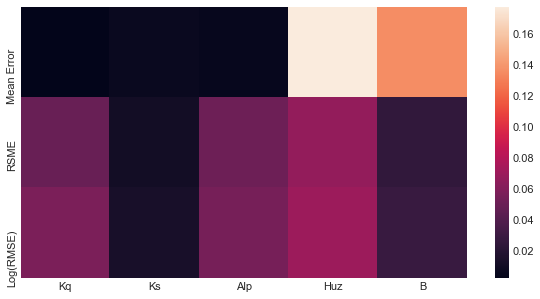

In [36]:
y_axis_labels = ['Mean Error', 'RSME', 'Log(RMSE)'] # labels for y-axis

# create seabvorn heatmap with required labels
plt.subplots(figsize=(10,5))
sns.heatmap(SA_df_4, yticklabels=y_axis_labels,  cmap='rocket')

In [25]:
SA_df_4

,Kq,Ks,Alp,Huz,B
0,0.048834,0.038918,0.041692,0.144394,0.186408
1,0.167574,0.060671,0.083906,0.082624,0.067440
2,0.177087,0.059413,0.083449,0.080558,0.065032


### 3-3 Comment on performance metrics
The results indicate that different goodness-of-fit metrics can produce different sensitivity indices. As mentioned earlier, this is because, streamflow time series have several dimensions (e.g., extreme high flow and low flow) and focusing on only one metric might neglect the sensitivity of other dimensions. 

Therefore, we can argue that a single goodness-of-fit measure will never be able to capture the entire response of model to different parametric combinations. For more discussion about this topic readers can refer to [Liu and Sun (2010)](https://www.sciencedirect.com/science/article/pii/S1574954110000580?via%3Dihub) and [Foglia et al, (2009)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008WR007255).

### 3-4 Sensitivity indecies based on water balance

Here we also calculate the sensitivity analysis indices based on water balance-related measures. More specifically, we focus on the ratio of runoff over rainfall that has been widely used to represent the partitioning of rainfall into different water balance components. We can use the following simple relationship to calculate the water balance index ( _WBI_ ).

$${WBI}_{sim} = ({\frac{Runoff_{sim}}{Precipitation}})$$

After that we can subtract $WBI_{obs}$ and calculate the error from that.

In [215]:
# Aggregate streamflow data to monthly time series
ym_Q_df=Q_df.groupby(['year', 'month'])
agg_ym_Q_df=ym_Q_df.aggregate(np.mean)

ym_leaf_data=leaf_data.iloc[1:3650,:].groupby(['year', 'month'])
agg_ym_leaf_data=ym_leaf_data.aggregate(np.mean)

agg_ym_leaf_data.loc[agg_ym_leaf_data.loc[:,"Precip"]==0,"Precip"]=0.01
WB_sim=me=agg_ym_Q_df.iloc[:,0:len(param_values_hymod)].apply(lambda x: x/agg_ym_leaf_data.loc[:,"Precip"], axis=0 )
WB_obs=agg_ym_leaf_data["Strmflw"]/agg_ym_leaf_data["Precip"]

WB_error=WB_sim.iloc[:,0:len(param_values_hymod)].apply(lambda x: (x-WB_obs)/WB_obs*100, axis=0 )


In [221]:
# Perform analysis
SA_df_WB=pd.DataFrame(np.zeros((len(agg_ym_leaf_data),5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
SA_df_WBT=pd.DataFrame(np.zeros((len(agg_ym_leaf_data),5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])


for i_ps in range(0, 120):
    Y=WB_error.iloc[i_ps,0:(WB_error.shape[1])].to_numpy()
    #Si = sobol.analyze(problem_hymod, Y, print_to_console=False)
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    SA_df_WB.iloc[i_ps,:]=np.maximum(Si['S1'], 0)
    SA_df_WBT.iloc[i_ps,:]=np.maximum(Si['delta'], 0)

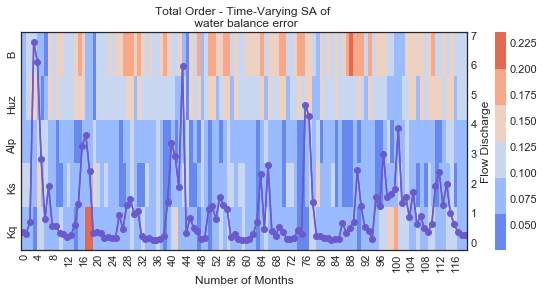

In [222]:
# Total order
SA_df_WBT_transposed=SA_df_WBT.T

fig_5WB, ax_fig_5WB=plt.subplots(figsize=(10,4))
sns.heatmap(SA_df_WBT_transposed, ax= ax_fig_5WB, cmap=sns.color_palette("coolwarm"))
axis_2 = ax_fig_5WB.twinx()
axis_2.plot(range(0,120), agg_ym_leaf_data['Strmflw'], color='slateblue')
axis_2.plot(range(0,120), agg_ym_leaf_data['Strmflw'], color='slateblue', marker='o')
ax_fig_5WB.set_ylim(0, 5)
ax_fig_5WB.set_xlim(-0.5, 119.5)
axis_2.set_ylabel('Flow Discharge')
ax_fig_5WB.set_xlabel('Number of Months')
plt.title('Total Order - Time-Varying SA of \n water balance error')

plt.show()


<a id='TVSA'></a> 
# 4- Time-Varying Sensitivity Analysis

Hydrological processes are often state-dependent, meaning that their responses are affected by the time-varying condition that they are in. For example, rainfall-runoff processes are different in winter and summer. These processes are also different during wet years and dry years.

Hydrological processes are also path-dependent, meaning that previous time-steps on the model affect the present and future simulation of different hydrologic components. To take these properties into account, we can zoom into different time periods to explore how the sensitivity of model parameters evolve in different time-step, this is usually referred to as time-varying sensitivity analysis.

For more information about time-varying sensitivity analysis readers can refer to [Herman et al. (2013)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20124) and [Xu et al. (2018)](https://link.springer.com/article/10.1007/s12206-018-0223-8).

### 4-1 Sensitivity analysis indices for each month
We can use the following to calculate the SA indices for each month and visualize it.

In [223]:
# Aggregate streamflow data to monthly time series
mm_Q_df=Q_df.groupby(['month'])
agg_mm_Q_df=mm_Q_df.aggregate(np.mean)

mm_leaf_data=leaf_data.iloc[1:3650,:].groupby(['month'])
agg_mm_leaf_data=mm_leaf_data.aggregate(np.mean)

# Perform analysis
SA_df_1=pd.DataFrame(np.zeros((12,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
SA_df_1T=pd.DataFrame(np.zeros((12,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])


for i_ps in range(0, 12):
    Y=agg_mm_Q_df.iloc[i_ps,1:(agg_mm_Q_df.shape[1])-2].to_numpy()
    #Si = sobol.analyze(problem_hymod, Y, print_to_console=False)
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    SA_df_1.iloc[i_ps,:]=np.maximum(Si['S1'], 0)
    SA_df_1T.iloc[i_ps,:]=np.maximum(Si['delta'], 0)

#### First order
The following can be used to visualize the time-varying first-order indices. The first order represents the direct impacts of a specific parameter on model outputs.

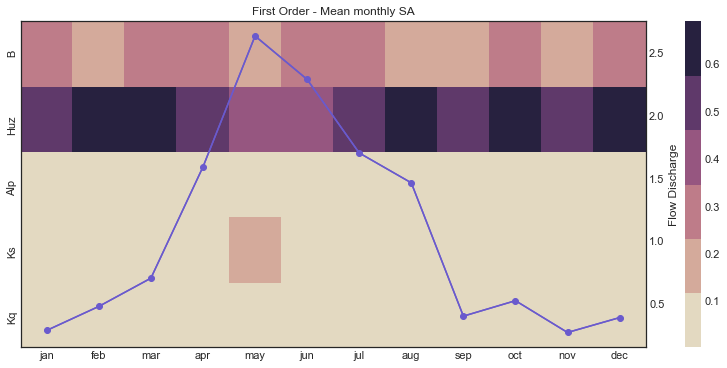

In [224]:
# Total order
SA_df_1_transposed=SA_df_1.T

fig_5WB, ax_fig_5WB=plt.subplots(figsize=(14,6))
sns.heatmap(SA_df_1_transposed, ax= ax_fig_5WB, cmap=sns.color_palette("ch:s=-.2,r=.6"))
axis_2 = ax_fig_5WB.twinx()
axis_2.plot(np.arange(0.5,12.5), agg_mm_leaf_data['Strmflw'], color='slateblue')
axis_2.plot(np.arange(0.5,12.5), agg_mm_leaf_data['Strmflw'], color='slateblue', marker='o')
ax_fig_5WB.set_ylim(0, 5)
ax_fig_5WB.set_xlim(0, 12)
ax_fig_5WB.set_xticklabels(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
axis_2.set_ylabel('Flow Discharge')
#ax_fig_5WB.set_xlabel('Number of Months')
plt.title('First Order - Mean monthly SA')

plt.show()


#### Total order
We can also focus on the total order sensitivity index that includes first-order SA indices and interactions between parameters

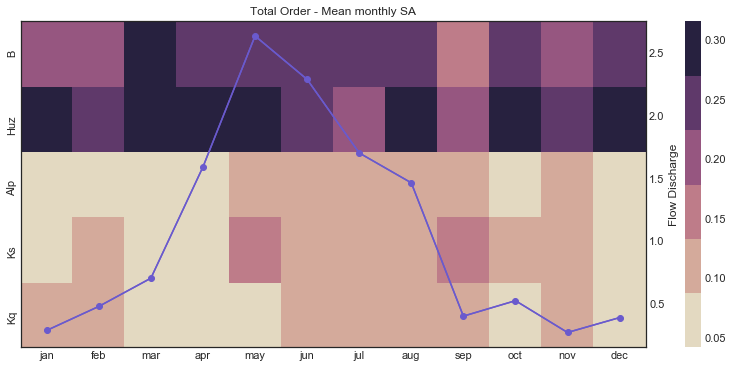

In [225]:
SA_df_1T_transposed=SA_df_1T.T

fig_5WB, ax_fig_5WB=plt.subplots(figsize=(14,6))
sns.heatmap(SA_df_1T_transposed, ax= ax_fig_5WB, cmap=sns.color_palette("ch:s=-.2,r=.6"))
axis_2 = ax_fig_5WB.twinx()
axis_2.plot(np.arange(0.5,12.5), agg_mm_leaf_data['Strmflw'], color='slateblue')
axis_2.plot(np.arange(0.5,12.5), agg_mm_leaf_data['Strmflw'], color='slateblue', marker='o')
ax_fig_5WB.set_ylim(0, 5)
ax_fig_5WB.set_xlim(0, 12)
ax_fig_5WB.set_xticklabels(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
axis_2.set_ylabel('Flow Discharge')
plt.title('Total Order - Mean monthly SA')

plt.show()


Based on our results **_Huz_** seems to be the most influential parameter. However, its influence declines during high-Flow months. Also, the sensitivity of the streamflow simulations to the **_B_** parameter and Soil hydraulic conductivity (**_K_s**) seems to significantly increase during high-flow months.

### 4-2 Annual sensitivity analysis indices

We can also calculate the sensitivity analysis indices for each individual year. This will us understand if model control changes during different years. The following code first aggregates the outputs to annual time steps, and then calculates the SA indices.

In [226]:
#----------  3
#------ Average annual indices

yy_Q_df=Q_df.groupby(['year'])
agg_yy_Q_df=yy_Q_df.aggregate(np.mean)

yy_leaf_data=leaf_data.iloc[1:3650,:].groupby(['year'])
agg_yy_leaf_data=yy_leaf_data.aggregate(np.mean)

# Perform analysis
SA_df_2=pd.DataFrame(np.zeros((10,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
SA_df_2T=pd.DataFrame(np.zeros((10,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

for i_ps in range(0, 10):
    Y=agg_yy_Q_df.iloc[i_ps,1:(agg_yy_Q_df.shape[1]-2)].to_numpy()
    #Si = sobol.analyze(problem_hymod, Y, print_to_console=False)
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    SA_df_2.iloc[i_ps,:]=np.maximum(Si['S1'], 0)
    SA_df_2T.iloc[i_ps,:]=np.maximum(Si['delta'], 0)
    

#### First order figure

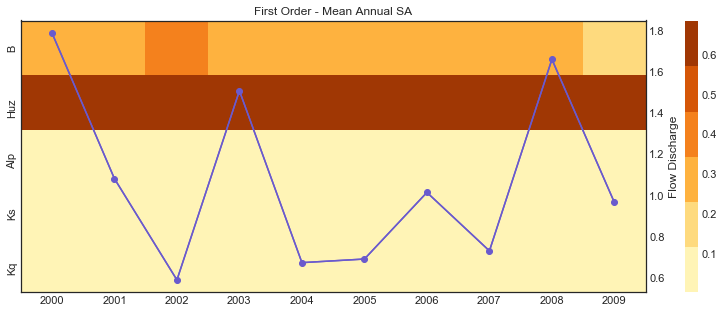

In [227]:
SA_df_2_transposed=SA_df_2.T

fig_5WB, ax_fig_5WB=plt.subplots(figsize=(14,5))
sns.heatmap(SA_df_2_transposed, ax= ax_fig_5WB, cmap=sns.color_palette("YlOrBr"))
axis_2 = ax_fig_5WB.twinx()

axis_2.plot(np.arange(0.5,10.5), agg_yy_leaf_data['Strmflw'], color='slateblue')
axis_2.plot(np.arange(0.5,10.5), agg_yy_leaf_data['Strmflw'], color='slateblue', marker='o')
ax_fig_5WB.set_ylim(0, 5)
ax_fig_5WB.set_xlim(0, 10)
ax_fig_5WB.set_yticklabels(['Kq', 'Ks', 'Alp', 'Huz', 'B'])
#ax_fig_5WB.set_xticks(range(0,5))
#ax_fig_5WB.set_xticks(range(0,10))
ax_fig_5WB.set_xticklabels(range(2000, 2010))
#ax_fig_5WB.set_xticklabels([2000, 2001, 2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010])
axis_2.set_ylabel('Flow Discharge')
plt.title('First Order - Mean Annual SA')
plt.show()

#### Total-order figure

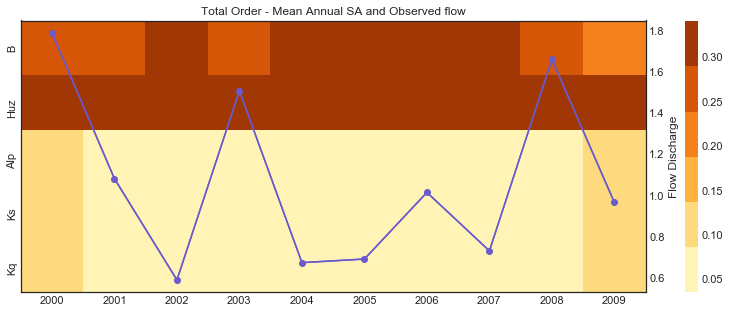

In [228]:
SA_df_2T_transposed=SA_df_2T.T

fig_5WB, ax_fig_5WB=plt.subplots(figsize=(14,5))
sns.heatmap(SA_df_2T_transposed, ax= ax_fig_5WB, cmap=sns.color_palette("YlOrBr"))
axis_2 = ax_fig_5WB.twinx()

axis_2.plot(np.arange(0.5,10.5), agg_yy_leaf_data['Strmflw'], color='slateblue')
axis_2.plot(np.arange(0.5,10.5), agg_yy_leaf_data['Strmflw'], color='slateblue', marker='o')
ax_fig_5WB.set_ylim(0, 5)
ax_fig_5WB.set_xlim(0, 10)
ax_fig_5WB.set_yticklabels(['Kq', 'Ks', 'Alp', 'Huz', 'B'])
#ax_fig_5WB.set_xticks(range(0,5))
#ax_fig_5WB.set_xticks(range(0,10))
ax_fig_5WB.set_xticklabels(range(2000, 2010))
#ax_fig_5WB.set_xticklabels([2000, 2001, 2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010])
axis_2.set_ylabel('Flow Discharge')
plt.title('Total Order - Mean Annual SA and Observed flow')
plt.show()

Our results indicate that sensitivity analysis indices vary in different years. However, it is generally hard to identify which state of the model affects sensitivity indices.

### 4-3 Monthly time-varying sensitivity analysis

Although time-varying sensitivity analysis at average monthly and average annual temporal resolutions is informative, TVSA is susceptible to the aggregation issue that we discussed earlier in section 3-2. To avoid that we can further discretize our time domain to zoom into individual months. This will provide us with even more information about model behavior and the sensitivity of different parameters in different states of the system.

In [229]:
ym_Q_df=Q_df.groupby(['year', 'month'])
agg_ym_Q_df=ym_Q_df.aggregate(np.mean)

ym_leaf_data=leaf_data.iloc[1:3650,:].groupby(['year', 'month'])
agg_ym_leaf_data=ym_leaf_data.aggregate(np.mean)

# Perform analysis
SA_df_3=pd.DataFrame(np.zeros((len(agg_ym_leaf_data),5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
SA_df_3T=pd.DataFrame(np.zeros((len(agg_ym_leaf_data),5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

for i_ps in range(0, 120):
    Y=agg_ym_Q_df.iloc[i_ps,1:(agg_ym_Q_df.shape[1]-1)].to_numpy()
    #Si = sobol.analyze(problem_hymod, Y, print_to_console=False)
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    SA_df_3.iloc[i_ps,:]=np.maximum(Si['S1'], 0)
    SA_df_3T.iloc[i_ps,:]=np.maximum(Si['delta'], 0)

#### First order - time varying sensitivity analysis

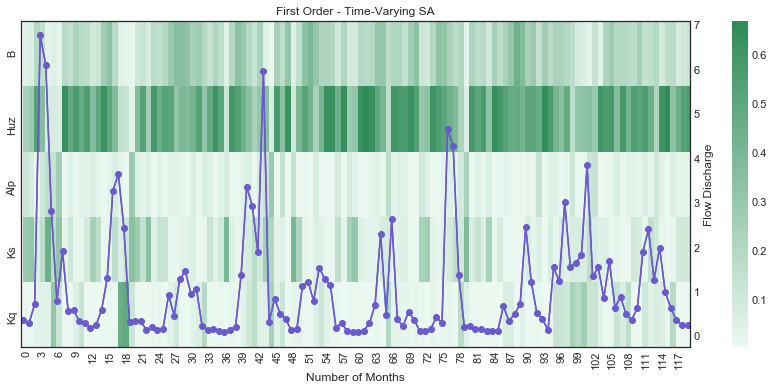

In [230]:
# First Order
SA_df_3_transposed=SA_df_3.T

fig_5, ax_fig_5=plt.subplots(figsize=(15,6))
sns.heatmap(SA_df_3_transposed, ax= ax_fig_5, cmap=sns.light_palette("seagreen", as_cmap=True))
axis_2 = ax_fig_5.twinx()
axis_2.plot(range(0,120), agg_ym_leaf_data['Strmflw'], color='slateblue')
axis_2.plot(range(0,120), agg_ym_leaf_data['Strmflw'], color='slateblue', marker='o')
ax_fig_5.set_ylim(0, 5)
ax_fig_5.set_xlim(-0.5, 119.5)
axis_2.set_ylabel('Flow Discharge')
ax_fig_5.set_xlabel('Number of Months')
plt.title('First Order - Time-Varying SA')

plt.show()

#### Total order - time varying sensitivity analysis

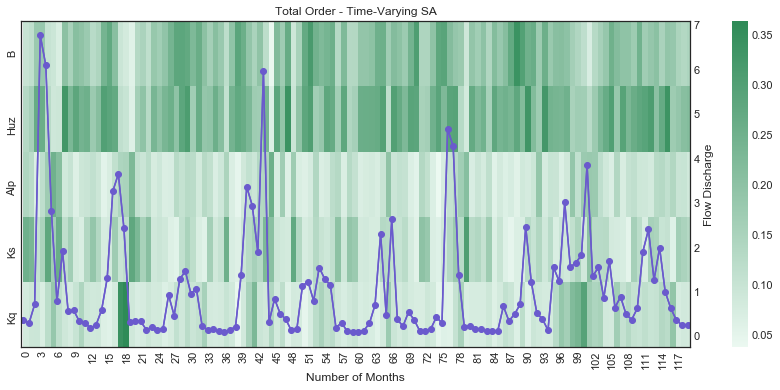

In [231]:
# Total order
SA_df_3T_transposed=SA_df_3T.T

fig_5, ax_fig_5=plt.subplots(figsize=(15,6))
sns.heatmap(SA_df_3T_transposed, ax= ax_fig_5, cmap=sns.light_palette("seagreen", as_cmap=True))
axis_2 = ax_fig_5.twinx()
axis_2.plot(range(0,120), agg_ym_leaf_data['Strmflw'], color='slateblue')
axis_2.plot(range(0,120), agg_ym_leaf_data['Strmflw'], color='slateblue', marker='o')
ax_fig_5.set_ylim(0, 5)
ax_fig_5.set_xlim(-0.5, 119.5)
axis_2.set_ylabel('Flow Discharge')
ax_fig_5.set_xlabel('Number of Months')
plt.title('Total Order - Time-Varying SA')

plt.show()

### 4-4 Comments on time varying sensitivity analysis
Here we show that we can calculate sensitivity indices for different months during the simulation period. This usually provides us with more information about parametric importance and model controls. Therefore, TVSA can be a helpful tool for model diagnostics studies.

Although we do not cover it here, we can also calculate sensitivity indices for specific events such as a specific drought event or a flood event.

<a id='RSA'></a> 
# 5- Regional Sensitivity Analysis

Regional sensitivity analysis is a sensitivity analysis technique that tries to find parameter sets that result in a specific condition in the output space. The parameter sets that satisfy our arbitrary condition are usually referred to as behavioral parameters, and the ones that do not satisfy the criteria are called non-behavioral. To do regional sensitivity analysis, we first need to come up with a design for our computational experiment, then model simulations are conducted. After that, model responses will be studied and outputs that satisfy a specific condition will be selected for further investigations. Finally, we can go back to the input datasets to find behavioral and non-behavioral parameter sets that correspond to our selected outputs. This can give a sense of what combinations of parameters can cause a specific behavior in the system.

As discussed in the main body of the white paper, regional sensitivity analysis has a close connection with many other SA concepts and methods such as factor mapping, GLUE, and pre-calibration that has been discussed in the next section.

In this example, we define non-behavioral samples as the ones that have more than 100% error.

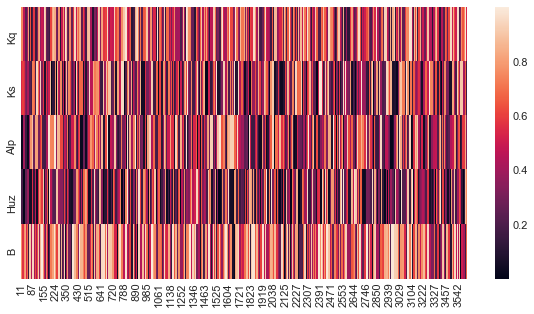

In [232]:
ym_Q_df=Q_df.groupby(['year', 'month'])
agg_ym_Q_df=ym_Q_df.aggregate(np.mean)

ym_leaf_data=leaf_data.iloc[1:3650,:].groupby(['year', 'month'])
agg_ym_leaf_data=ym_leaf_data.aggregate(np.mean)

Error=agg_ym_Q_df.sub(agg_ym_leaf_data['Strmflw'], axis=0).div(agg_ym_leaf_data['Strmflw'], axis=0)*100
avg_error=Error.mean(axis=0)
avg_error=pd.DataFrame(avg_error[1:(Q_df.shape[1]-3)], columns=['average_error'])
avg_error['num']=range(0,len(avg_error))

# Define non-physical or non-behavioral samples as error more than 100%
bad_samples=avg_error[avg_error['average_error']>100]

param_values_hymod_df=pd.DataFrame(param_values_hymod, columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
subset_bad_params=param_values_hymod_df.iloc[bad_samples['num']-1,:]

# Here we normalize the paramters so that they all flactuate between 0 and 1. 
subset_bad_params_transposed=subset_bad_params.T
subset_bad_params_transposed.iloc[1,:]=subset_bad_params_transposed.iloc[1,:]/0.1
subset_bad_params_transposed.iloc[3,:]=subset_bad_params_transposed.iloc[3,:]/500
subset_bad_params_transposed.iloc[4,:]=subset_bad_params_transposed.iloc[4,:]/2

fig_6, ax_fig_6=plt.subplots(figsize=(10,5))
sns.heatmap(subset_bad_params_transposed, ax= ax_fig_6, cmap='rocket')



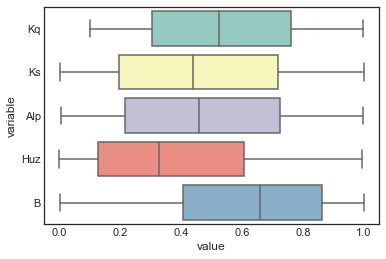

In [233]:
to_plot_0=pd.melt(subset_bad_params_transposed.T,  value_vars =['Kq', 'Ks', 'Alp', 'Huz', 'B']) 

g=sns.boxplot("value", "variable", data=to_plot_0, palette="Set3")


As our results show, we are not able to detect a clear range of variable that causes high errors and unreasonable streamflow simulations. 

Also, defining a specific threshold for non-behavioral parameters is often very challenging, we will explore this a little bit more in the following sections.

<a id='GLUE'></a> 
# 6- Generalized Likelihood Uncertainty Estimation (GLUE)

The Generalized Likelihood Uncertainty Estimation (GLUE) is an uncertainty analysis algorithm that has been widely used in hydrologic studies. The main argument behind GLUE is rooted in model calibration and the concept of equifinality. Basically, calibration of complex simulation tools such as hydrological models often produces more than one optimal or near-optimal solutions, these solutions have equivalent chances to be chosen [(Beven and Freer, 2001)](https://www.sciencedirect.com/science/article/abs/pii/S0022169401004218). This situation is called equifinality. GLUE provides a methodological framework to handle this problem and consider more than one optimal calibration- sets.

GLUE usually includes the following steps [(Beven and Bineley, 1992)](https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.3360060305?casa_token=o2ooj-6wmC4AAAAA:WpVg1ysAtD59QbSpdHKX6IOjfjeHsOfqxCC6RvoXgiW6bDBRGNfdkOv-AH6h3WhT7-2mD4xmwzMi):

1- Definition of a likelihood function  <br>
2- Definition of ranges of parameters <br>
3- Sensitivity analysis <br>
4- Calculating likelihood (goodness-of-fit) values for each model simulation <br>
5- Define a threshold and find sample sets that have higher likelihoods than the threshold <br>
6- Visualize the sample sets <br>

### 6-1 Calculation of GLUE metrics

#### Likelihood calculation (inverse error variance)
There are various likelihood metrics that have been used in previous studies that use GLUE. A widley used example is inverse error variance (IEV; [Vrugt et al. 2009](https://link.springer.com/article/10.1007/s00477-008-0274-y) and [Beven and Bineley, 1992](https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.3360060305?casa_token=o2ooj-6wmC4AAAAA:WpVg1ysAtD59QbSpdHKX6IOjfjeHsOfqxCC6RvoXgiW6bDBRGNfdkOv-AH6h3WhT7-2mD4xmwzMi)): 

$$ IEV = {({\sigma_{e}}^{2})}^{-T} = ({{\frac{SSR}{n-2}}})^{-T} $$

The other metric that can be used as an estimation of likelihood is normalized inverse error variance:
$$ NIEV = \frac{IEV}{\sum_{i=1}^{n} IEV(i)} $$

where *SSR* is the sum of squared residuals; *n* is the number of samples; and *T* is an arbitrary coefficient. Low T values lead gives equal weights to each sample set while higher T values concentrate on the best parameter sets.

In [234]:
# From Vrugt et al (2008) : inverse error variance


T= 0.70 # T=0 --> We only select the best simulated values that are closer to the observed values and T=infinity --> all sample sets have the same probability

df_metrics_SA.loc[:,"SSR"]=df_metrics_SA.loc[:,"RMSE"]**2*3650
df_metrics_SA.loc[:,"InverseErrorVariance"]=(df_metrics_SA.loc[:,"SSR"]/(df_metrics_SA.loc[:,"SSR"].shape[0]-2))**(-T) #Beven and Binley, 1992
df_metrics_SA.loc[:,"Normalized_IEV"]=df_metrics_SA.loc[:,"InverseErrorVariance"]/df_metrics_SA.loc[:,"InverseErrorVariance"].sum() #Beven and Binley, 1992

param_values_hymod_df=pd.DataFrame(param_values_hymod, columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

concat_df=pd.concat([df_metrics_SA, param_values_hymod_df], axis=1)
concat_df["Ks_rescale"]=concat_df.loc[:, "Ks"]/0.1
concat_df["Huz_rescale"]=concat_df.loc[:, "Huz"]/500
concat_df["B_rescale"]=concat_df.loc[:, "B"]/2

In [235]:
df_metrics_SA

,ME,RMSE,LOG[RMSE],SSR,InverseErrorVariance,Normalized_IEV
0,0.428537,1.980948,0.296873,14323.170168,0.380203,0.000274
1,-0.071298,2.129909,0.328361,16558.275553,0.343504,0.000248
2,-0.071620,1.669985,0.222713,10179.303219,0.482881,0.000349
3,-0.058859,2.143209,0.331065,16765.710223,0.340524,0.000246
4,-0.084092,2.153719,0.333189,16930.542762,0.338200,0.000244
...,...,...,...,...,...,...
3595,0.164234,1.974670,0.295494,14232.519167,0.381896,0.000276
3596,0.152377,1.653976,0.218529,9985.068257,0.489437,0.000353
3597,0.162833,1.807878,0.257169,11929.744061,0.432117,0.000312
3598,0.412018,1.854194,0.268155,12548.832784,0.417081,0.000301


#### Distribution of likelihoods (inverse error variance) values

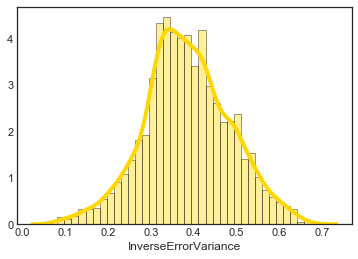

In [236]:
# Density Plot and Histogram of all arrival delays
sns.distplot(df_metrics_SA.loc[:,"InverseErrorVariance"], hist=True, kde=True, 
             bins=int(180/5), color = 'gold', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

#### Distribution of normalized inverse error variance values

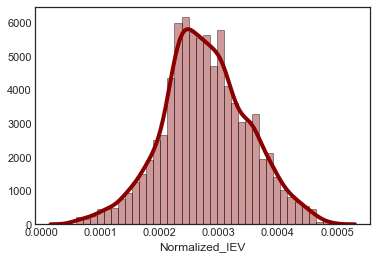

In [237]:

# Density Plot and Histogram of all arrival delays
sns.distplot(df_metrics_SA.loc[:,"Normalized_IEV"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

#### Selection of important sample sets

In [238]:
# selection of important sample sets
percentile=95
threshold=np.percentile(concat_df.loc[:,"InverseErrorVariance"], percentile)
print("threshold = ", str(threshold))
selected_values=concat_df[concat_df.loc[:,"InverseErrorVariance"]>threshold]


threshold =  0.5543057043138593


### 6-2 Visual inspection of GLUE results

In [239]:
# Name is id_vars and Course is value_vars 
to_plot=pd.melt(selected_values, id_vars =['ME'], value_vars =['Kq', 'Ks_rescale', 'Alp', 'Huz_rescale', 'B_rescale']) 

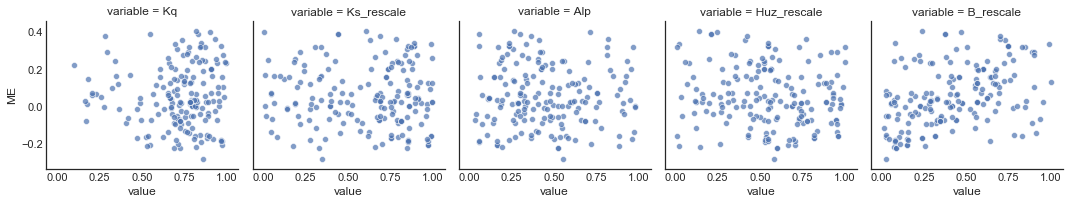

In [240]:
g = sns.FacetGrid(to_plot, col="variable")
g.map(sns.scatterplot, "value","ME",  alpha=.7)
g.add_legend()

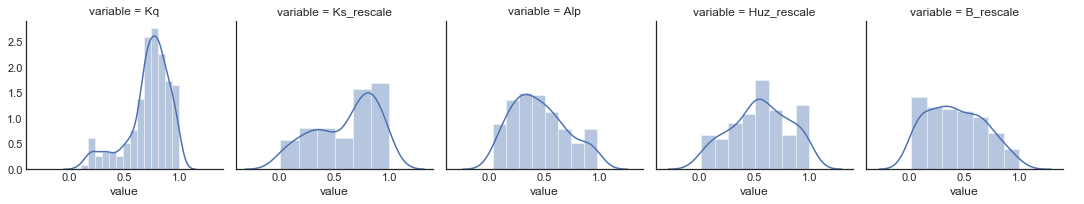

In [241]:
g_2 = sns.FacetGrid(to_plot, col="variable")
g_2.map(sns.distplot, "value")
g_2.add_legend()

#### Results

Our results suggest that it is challenging to find an clear and interpretable relationship between different selected near-optimal sample sets at least by visual inspection. The main reason is that HYMOD includes a complex non-linear system of equations that is also affected by initial conditions and complexity of its input time series. Therefore, it does not have a clear control.

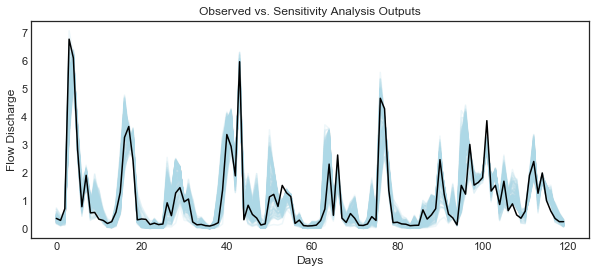

In [242]:
#------ mean monthly indices 

date_ts=pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year']=date_ts.year
Q_df['month']=date_ts.month
Q_df['day']=date_ts.day

Q_df_beh=pd.concat([Q_df.iloc[:,selected_values.index], Q_df.loc[:,['month' , 'year']]], axis=1) 

m_Q_beh_df=Q_df_beh.groupby(['year', 'month'])
agg_m_Q_beh_df=m_Q_beh_df.aggregate(np.mean)

date_ts=pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year']=date_ts.year
leaf_data['month']=date_ts.month
leaf_data['day']=date_ts.day

m_leaf_data=leaf_data.groupby(['year', 'month'])
agg_m_leaf_data=m_leaf_data.aggregate(np.mean)


fig_2_2, ax_fig_2_2=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(agg_m_Q_beh_df)), agg_m_Q_beh_df.iloc[:,2],  color="pink", alpha=0.2)
ax_fig_2_2.set_xlabel('Days')
ax_fig_2_2.set_ylabel('Flow Discharge')
#ax_fig_2.set_facecolor('white')

for i_ps in range(0, agg_m_Q_beh_df.shape[1]):
    plt.plot(range(0, agg_m_Q_beh_df.shape[0]), agg_m_Q_beh_df.iloc[:,i_ps],  color="lightblue", alpha=0.2)

plt.plot(range(0, len(agg_m_Q_beh_df)), agg_m_leaf_data.iloc[0:len(agg_m_Q_beh_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs')

plt.show()

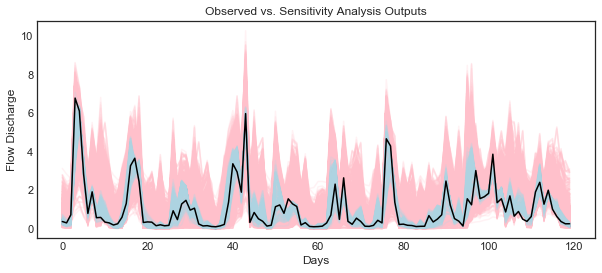

In [243]:
#------ mean monthly indices 

date_ts=pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year']=date_ts.year
Q_df['month']=date_ts.month
Q_df['day']=date_ts.day

Q_df_beh=pd.concat([Q_df.iloc[:,selected_values.index], Q_df.loc[:,['month' , 'year']]], axis=1) 

m_Q_beh_df=Q_df_beh.groupby(['year', 'month'])
agg_m_Q_beh_df=m_Q_beh_df.aggregate(np.mean)

date_ts=pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year']=date_ts.year
leaf_data['month']=date_ts.month
leaf_data['day']=date_ts.day

m_leaf_data=leaf_data.groupby(['year', 'month'])
agg_m_leaf_data=m_leaf_data.aggregate(np.mean)


fig_2_2, ax_fig_2_2=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(agg_m_Q_beh_df)), agg_m_Q_beh_df.iloc[:,2],  color="pink", alpha=0.2)
ax_fig_2_2.set_xlabel('Days')
ax_fig_2_2.set_ylabel('Flow Discharge')
#ax_fig_2.set_facecolor('white')

for i_ps in range(0, len(param_values_hymod)):
    plt.plot(range(0, len(agg_m_Q_df)), agg_m_Q_df.iloc[:,i_ps],  color="pink", alpha=0.2)
    
for i_ps in range(0, agg_m_Q_beh_df.shape[1]):
    plt.plot(range(0, agg_m_Q_beh_df.shape[0]), agg_m_Q_beh_df.iloc[:,i_ps],  color="lightblue", alpha=0.2)

plt.plot(range(0, len(agg_m_Q_beh_df)), agg_m_leaf_data.iloc[0:len(agg_m_Q_beh_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs')

plt.show()

### 6-3 Comment on the GLUE results

Glue has been widely used in hydrology, the original paper has more than 5000 citations. However, the likelihood measure that GLUE uses is not actually a statistically sound likelihood metric and is in fact a goodness-of-fit measure. Therefore, it might not produce valid insights when dealing with situations of non-normality, heteroscedasticity, and serial correlation. For more on these issues reader can refer to [Stedinger et al, (2008)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008WR006822%4010.1002/%28ISSN%291944-7973.ASSESS1), [Mantovan and Todini, (2006)](https://www.sciencedirect.com/science/article/pii/S0022169406002162?casa_token=Ml8dhBrO5PkAAAAA:Ake1YuQo0OxK6BaaG-8wIdHa_kd4cuUpm7WiHBFur-G_DlRze6Z0_GkwWH3qHDLKwbJDO9mN), and [Beven And Binley, (2014)](https://onlinelibrary.wiley.com/doi/full/10.1002/hyp.10082).

<a id='precalibration'></a> 
# 7- Pre-Calibration

Pre-calibration [(Edwards et al, 2010)](https://link.springer.com/article/10.1007/s00382-010-0921-0) is a simplified method to deal with uncertainty in complex environmental models. Pre-calibration can also be thought of as another method that tackles the shortcomings and conceptual challenges involved in calibration of complex environmental models. In pre-calibration instead of finding the best solutions, we focus on finding the sample sets that create outputs that are against the common understanding of the system. These parameter sets are called non-physical parameter sets. In other words, the probability that these parameters are among the best sample sets is zero or near zero and can be neglected in practice.

 
Pre-calibration can include the following steps: <br>
1- Sensitivity analysis <br>
2- Definition of non-physical boundaries <br>
3- Delineating regions in the output space which are non-physical (Implausible) <br>
4- Map non-physical sets back to input space <br>
5- Interpret the non-physical sample sets <br>

### 7-1 Pre-calibration calulations

#### Distribution of mean error, RMSE, and Log[RMSE] under different sample sets

Text(0.5, 1.0, 'Distribution of LOG[RMSE] in Different Sample Sets')

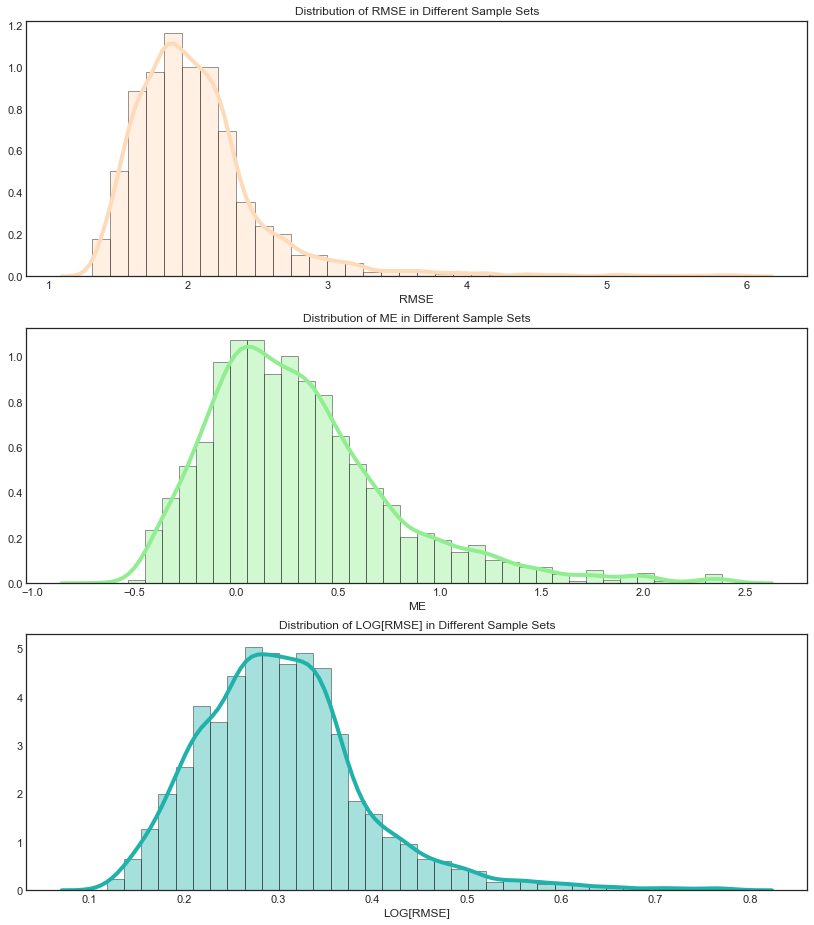

In [244]:
# PDF of RMSE values

fig, axs = plt.subplots(nrows=3, figsize=(14,16))

sns.distplot(concat_df.loc[:,"RMSE"], ax=axs[0], hist=True, kde=True, 
             bins=int(180/5), color = 'peachpuff', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Distribution of RMSE in Different Sample Sets')

sns.distplot(concat_df.loc[:,"ME"],ax=axs[1], hist=True, kde=True, 
             bins=int(180/5), color = 'lightgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Distribution of ME in Different Sample Sets')

sns.distplot(concat_df.loc[:,"LOG[RMSE]"],ax=axs[2], hist=True, kde=True, 
             bins=int(180/5), color = 'lightseagreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Distribution of LOG[RMSE] in Different Sample Sets')

#### Setting a threshold for physical/non-pysical sample sets

In [245]:
# selection of physical/non-physical sample sets
percentile=95
threshold_precal=np.percentile(concat_df.loc[:,"RMSE"], percentile)
print("threshold = ", str(threshold_precal))
selected_values_precal=concat_df[concat_df.loc[:,"RMSE"]>threshold_precal]


threshold =  2.935541853111823


#### Visual inspection of non-physical sample sets

In [246]:
# Name is id_vars and Course is value_vars 
to_plot_precal=pd.melt(selected_values_precal, id_vars =['ME'], value_vars =['Kq', 'Ks_rescale', 'Alp', 'Huz_rescale', 'B_rescale']) 

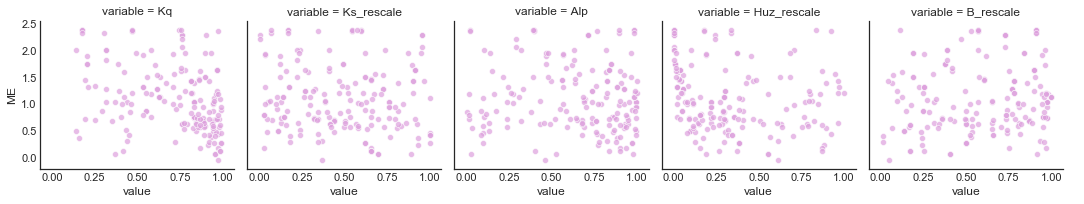

In [247]:
g = sns.FacetGrid(to_plot_precal, col="variable")
g.map(sns.scatterplot, "value","ME",  alpha=.7, color = 'plum')
g.add_legend()

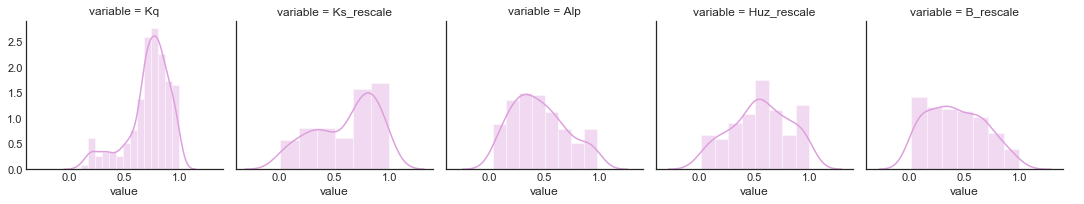

In [248]:
g_2 = sns.FacetGrid(to_plot, col="variable")
g_2.map(sns.distplot, "value", color = 'plum')
g_2.add_legend()

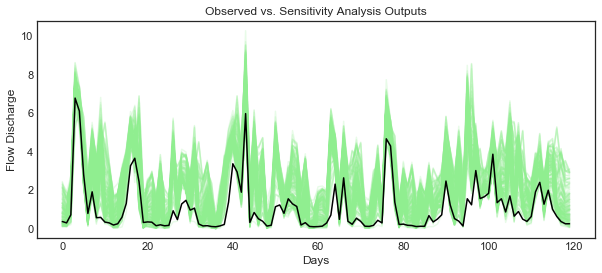

In [249]:
#------ mean monthly indices 

date_ts=pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year']=date_ts.year
Q_df['month']=date_ts.month
Q_df['day']=date_ts.day

Q_df_precal=pd.concat([Q_df.iloc[:,selected_values_precal.index], Q_df.loc[:,['month' , 'year']]], axis=1) 

m_Q_precal_df=Q_df_precal.groupby(['year', 'month'])
agg_m_precal_df=m_Q_precal_df.aggregate(np.mean)

date_ts=pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year']=date_ts.year
leaf_data['month']=date_ts.month
leaf_data['day']=date_ts.day

m_leaf_data=leaf_data.groupby(['year', 'month'])
agg_m_leaf_data=m_leaf_data.aggregate(np.mean)


fig_2_3, ax_fig_2_3=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(agg_m_precal_df)), agg_m_precal_df.iloc[:,2],  color="lightgreen", alpha=0.2)
ax_fig_2_3.set_xlabel('Days')
ax_fig_2_3.set_ylabel('Flow Discharge')
#ax_fig_2.set_facecolor('white')

for i_ps in range(0, agg_m_precal_df.shape[1]):
    plt.plot(range(0, agg_m_precal_df.shape[0]), agg_m_precal_df.iloc[:,i_ps],  color="lightgreen", alpha=0.2)


plt.plot(range(0, len(agg_m_precal_df)), agg_m_leaf_data.iloc[0:len(agg_m_Q_beh_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs')

plt.show()

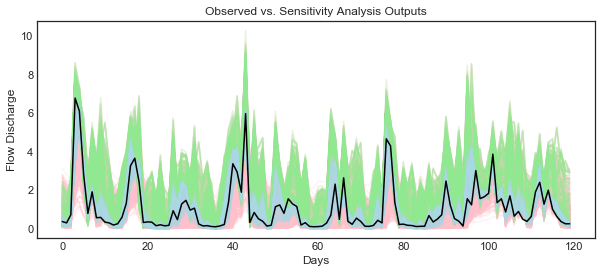

In [250]:
#------ mean monthly indices 

date_ts=pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year']=date_ts.year
Q_df['month']=date_ts.month
Q_df['day']=date_ts.day

Q_df_precal=pd.concat([Q_df.iloc[:,selected_values_precal.index], Q_df.loc[:,['month' , 'year']]], axis=1) 

m_Q_precal_df=Q_df_precal.groupby(['year', 'month'])
agg_m_precal_df=m_Q_precal_df.aggregate(np.mean)

date_ts=pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year']=date_ts.year
leaf_data['month']=date_ts.month
leaf_data['day']=date_ts.day

m_leaf_data=leaf_data.groupby(['year', 'month'])
agg_m_leaf_data=m_leaf_data.aggregate(np.mean)


fig_2_3_2, ax_fig_2_3_2=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(agg_m_precal_df)), agg_m_precal_df.iloc[:,2],  color="lightgreen", alpha=0.2)
ax_fig_2_3_2.set_xlabel('Days')
ax_fig_2_3_2.set_ylabel('Flow Discharge')
#ax_fig_2.set_facecolor('white')

# This for loop prints all simulated streamflow cases under different sample sets 
for i_ps in range(0, len(param_values_hymod)):
    plt.plot(range(0, len(agg_m_Q_df)), agg_m_Q_df.iloc[:,i_ps],  color="pink", alpha=0.2)

for i_ps in range(0, agg_m_precal_df.shape[1]):
    plt.plot(range(0, agg_m_precal_df.shape[0]), agg_m_precal_df.iloc[:,i_ps],  color="lightgreen", alpha=0.2)

for i_ps in range(0, agg_m_Q_beh_df.shape[1]):
    plt.plot(range(0, agg_m_Q_beh_df.shape[0]), agg_m_Q_beh_df.iloc[:,i_ps],  color="lightblue", alpha=0.2)


plt.plot(range(0, len(agg_m_precal_df)), agg_m_leaf_data.iloc[0:len(agg_m_Q_beh_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs')

plt.show()

### 7-2 Comments on Pre-Calibration

Although Pre-calibrations provides a helpful and relatively simple alternative for statistical inferences, it has some disadvantages. For example, it is often subjective and challenging to provide a threshold for non-physical model outputs. Moreover, as discussed earlier different goodness-of-fit metrics can produce distinct physical and non-physical sample sets. 

More information about pre-calibration can be found in [(Edwards et al, 2010)](https://link.springer.com/article/10.1007/s00382-010-0921-0), and  [Ruckert et al, (2017)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0170052).